In [1]:
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
df = pd.read_csv('amazon_reviews_us_Mobile_Electronics_v1_00.tsv', sep = '\t', error_bad_lines = False)
# https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt

b'Skipping line 35246: expected 15 fields, saw 22\n'
b'Skipping line 87073: expected 15 fields, saw 22\n'


In [3]:
df.shape

(104852, 15)

In [4]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,20422322,R8MEA6IGAHO0B,B00MC4CED8,217304173,BlackVue DR600GW-PMP,Mobile_Electronics,5.0,0.0,0.0,N,Y,Very Happy!,"As advertised. Everything works perfectly, I'm...",2015-08-31
1,US,40835037,R31LOQ8JGLPRLK,B00OQMFG1Q,137313254,GENSSI GSM / GPS Two Way Smart Phone Car Alarm...,Mobile_Electronics,5.0,0.0,1.0,N,Y,five star,it's great,2015-08-31
2,US,51469641,R2Y0MM9YE6OP3P,B00QERR5CY,82850235,iXCC Multi pack Lightning cable,Mobile_Electronics,5.0,0.0,0.0,N,Y,great cables,These work great and fit my life proof case fo...,2015-08-31
3,US,4332923,RRB9C05HDOD4O,B00QUFTPV4,221169481,abcGoodefg® FBI Covert Acoustic Tube Earpiece ...,Mobile_Electronics,4.0,0.0,0.0,N,Y,Work very well but couldn't get used to not he...,Work very well but couldn't get used to not he...,2015-08-31
4,US,44855305,R26I2RI1GFV8QG,B0067XVNTG,563475445,Generic Car Dashboard Video Camera Vehicle Vid...,Mobile_Electronics,2.0,0.0,0.0,N,Y,Cameras has battery issues,"Be careful with these products, I have bought ...",2015-08-31


In [5]:
df = df[df['verified_purchase'] == "Y"]

In [6]:
df.isnull().sum()

marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      2
review_body          0
review_date          0
dtype: int64

In [7]:
df.dropna(axis = 0, inplace = True)
df.reset_index(drop = True, inplace = True)

In [8]:
reviews_data = df[['star_rating','review_body']]
reviews_data = reviews_data.drop_duplicates()
reviews_data.shape

(86277, 2)

In [9]:
reviews_data.head()

,star_rating,review_body
0,5.0,"As advertised. Everything works perfectly, I'm..."
1,5.0,it's great
2,5.0,These work great and fit my life proof case fo...
3,4.0,Work very well but couldn't get used to not he...
4,2.0,"Be careful with these products, I have bought ..."


In [10]:
reviews_data['star_rating'].value_counts()

5.0    42651
4.0    15282
1.0    14056
3.0     8244
2.0     6044
Name: star_rating, dtype: int64

In [11]:
reviews_5_df = reviews_data[reviews_data.star_rating == 5.0]
reviews_4_df = reviews_data[reviews_data.star_rating == 4.0]
reviews_3_df = reviews_data[reviews_data.star_rating == 3.0]
reviews_2_df = reviews_data[reviews_data.star_rating == 2.0]
reviews_1_df = reviews_data[reviews_data.star_rating == 1.0]

reviews_5_df.reset_index(drop = True, inplace = True)
reviews_4_df.reset_index(drop = True, inplace = True)
reviews_3_df.reset_index(drop = True, inplace = True)
reviews_2_df.reset_index(drop = True, inplace = True)
reviews_1_df.reset_index(drop = True, inplace = True)

reviews_1_df_upsampled = resample(reviews_1_df, 
                                 replace = True,    
                                 n_samples = 30000,   
                                 random_state = 42)

reviews_2_df_upsampled = resample(reviews_2_df, 
                                 replace = True,    
                                 n_samples = 30000,   
                                 random_state = 42)

reviews_3_df_upsampled = resample(reviews_3_df, 
                                 replace = True,    
                                 n_samples = 30000,   
                                 random_state = 42)

reviews_4_df_upsampled = resample(reviews_4_df, 
                                 replace = True,    
                                 n_samples = 30000,   
                                 random_state = 42)

reviews_5_df_downsampled = resample(reviews_5_df, 
                                 replace = True,    
                                 n_samples = 30000,   
                                 random_state = 42)

reviews_1_df_upsampled.reset_index(drop = True, inplace = True)
reviews_2_df_upsampled.reset_index(drop = True, inplace = True)
reviews_3_df_upsampled.reset_index(drop = True, inplace = True)
reviews_4_df_upsampled.reset_index(drop = True, inplace = True)
reviews_5_df_downsampled.reset_index(drop = True, inplace = True)

In [12]:
reviews_data = pd.concat([reviews_1_df_upsampled, reviews_2_df_upsampled, reviews_3_df_upsampled, reviews_4_df_upsampled, reviews_5_df_downsampled], axis = 0)
reviews_data = reviews_data.sample(frac = 1) 
reviews_data.reset_index(drop = True, inplace = True)
reviews_data.head()

,star_rating,review_body
0,4.0,they were cheap and easy to install. way bette...
1,1.0,I wouldn't really even give this one star. Whe...
2,4.0,My 10 year old bought this for his new ipod an...
3,1.0,"Case looks nice and fits great, however can't ..."
4,5.0,My previous Kindle Fire case was getting dull ...


In [13]:
reviews_data['star_rating'].value_counts()

1.0    30000
5.0    30000
3.0    30000
2.0    30000
4.0    30000
Name: star_rating, dtype: int64

In [14]:
reviews_data["review_body"] = reviews_data["review_body"].str.lower()

In [15]:
reviews_data["reviews_pun_off"] = reviews_data["review_body"]
for i in string.punctuation:
    if i == "'":
        reviews_data["reviews_pun_off"] = reviews_data["reviews_pun_off"].str.replace(i,'')
    else:
        reviews_data["reviews_pun_off"] = reviews_data["reviews_pun_off"].str.replace(i,' ')  
reviews_data.head()

,star_rating,review_body,reviews_pun_off
0,4.0,they were cheap and easy to install. way bette...,they were cheap and easy to install way bette...
1,1.0,i wouldn't really even give this one star. whe...,i wouldnt really even give this one star when...
2,4.0,my 10 year old bought this for his new ipod an...,my 10 year old bought this for his new ipod an...
3,1.0,"case looks nice and fits great, however can't ...",case looks nice and fits great however cant s...
4,5.0,my previous kindle fire case was getting dull ...,my previous kindle fire case was getting dull ...


In [16]:
customized_stop_words = "i,me,my,myself,we,our,ours,ourselves,you,you're,you've,you'll,you'd,your,yours,yourself,yourselves,he,him,his,himself,she,she's,her,hers,herself,it,it's,its,itself,they,them,their,theirs,themselves,what,which,who,whom,this,that,that'll,these,those,am,is,are,was,were,be,been,being,have,has,had,having,do,does,did,doing,a,an,the,and,but,if,or,because,as,until,while,of,at,by,for,with,about,against,between,into,through,during,before,after,above,below,to,from,up,down,in,out,on,off,over,under,again,further,then,once,here,there,when,where,why,how,all,any,both,each,few,more,most,other,some,such,own,same,s,t,can,will,just,can,will,just,should,should've,now,d,ll,m,o,re,ve,y,ma".split(',')

In [17]:
stop = stopwords.words('english')
def remove_stopwords(review):
    return " ".join([i for i in str(review).split() if i not in customized_stop_words])
reviews_data["reviews_stop_rem"] = reviews_data["reviews_pun_off"].apply(lambda review: remove_stopwords(review))
reviews_data.head()

,star_rating,review_body,reviews_pun_off,reviews_stop_rem
0,4.0,they were cheap and easy to install. way bette...,they were cheap and easy to install way bette...,cheap easy install way better cheap stock ones...
1,1.0,i wouldn't really even give this one star. whe...,i wouldnt really even give this one star when...,wouldnt really even give one star got product ...
2,4.0,my 10 year old bought this for his new ipod an...,my 10 year old bought this for his new ipod an...,10 year old bought new ipod loves job perfectl...
3,1.0,"case looks nice and fits great, however can't ...",case looks nice and fits great however cant s...,case looks nice fits great however cant say pr...
4,5.0,my previous kindle fire case was getting dull ...,my previous kindle fire case was getting dull ...,previous kindle fire case getting dull worn lo...


In [18]:
def remove_2_letter_words(review):
    return " ".join([i for i in str(review).split() if len(i) > 2])
reviews_data["reviews_after_2_letter_rem"] = reviews_data["reviews_stop_rem"].apply(lambda review: remove_2_letter_words(review))
reviews_data.head()

,star_rating,review_body,reviews_pun_off,reviews_stop_rem,reviews_after_2_letter_rem
0,4.0,they were cheap and easy to install. way bette...,they were cheap and easy to install way bette...,cheap easy install way better cheap stock ones...,cheap easy install way better cheap stock ones...
1,1.0,i wouldn't really even give this one star. whe...,i wouldnt really even give this one star when...,wouldnt really even give one star got product ...,wouldnt really even give one star got product ...
2,4.0,my 10 year old bought this for his new ipod an...,my 10 year old bought this for his new ipod an...,10 year old bought new ipod loves job perfectl...,year old bought new ipod loves job perfectly l...
3,1.0,"case looks nice and fits great, however can't ...",case looks nice and fits great however cant s...,case looks nice fits great however cant say pr...,case looks nice fits great however cant say pr...
4,5.0,my previous kindle fire case was getting dull ...,my previous kindle fire case was getting dull ...,previous kindle fire case getting dull worn lo...,previous kindle fire case getting dull worn lo...


In [19]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatize_words(review):
    return " ".join([lemmatizer.lemmatize(word) for word in review.split()])

reviews_data["reviews_lemmatized"] = reviews_data["reviews_after_2_letter_rem"].apply(lambda review: lemmatize_words(review))
reviews_data.head()

[nltk_data] Downloading package wordnet to /home/harrish/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,star_rating,review_body,reviews_pun_off,reviews_stop_rem,reviews_after_2_letter_rem,reviews_lemmatized
0,4.0,they were cheap and easy to install. way bette...,they were cheap and easy to install way bette...,cheap easy install way better cheap stock ones...,cheap easy install way better cheap stock ones...,cheap easy install way better cheap stock one ...
1,1.0,i wouldn't really even give this one star. whe...,i wouldnt really even give this one star when...,wouldnt really even give one star got product ...,wouldnt really even give one star got product ...,wouldnt really even give one star got product ...
2,4.0,my 10 year old bought this for his new ipod an...,my 10 year old bought this for his new ipod an...,10 year old bought new ipod loves job perfectl...,year old bought new ipod loves job perfectly l...,year old bought new ipod love job perfectly lo...
3,1.0,"case looks nice and fits great, however can't ...",case looks nice and fits great however cant s...,case looks nice fits great however cant say pr...,case looks nice fits great however cant say pr...,case look nice fit great however cant say prot...
4,5.0,my previous kindle fire case was getting dull ...,my previous kindle fire case was getting dull ...,previous kindle fire case getting dull worn lo...,previous kindle fire case getting dull worn lo...,previous kindle fire case getting dull worn lo...


In [20]:
def remove_invalid_words(review):
    return " ".join([i for i in str(review).split() if i.isalpha()])

reviews_data["reviews_invalid_words_rem"] = reviews_data["reviews_lemmatized"].apply(lambda review: remove_invalid_words(review))
reviews_data.head()

,star_rating,review_body,reviews_pun_off,reviews_stop_rem,reviews_after_2_letter_rem,reviews_lemmatized,reviews_invalid_words_rem
0,4.0,they were cheap and easy to install. way bette...,they were cheap and easy to install way bette...,cheap easy install way better cheap stock ones...,cheap easy install way better cheap stock ones...,cheap easy install way better cheap stock one ...,cheap easy install way better cheap stock one ...
1,1.0,i wouldn't really even give this one star. whe...,i wouldnt really even give this one star when...,wouldnt really even give one star got product ...,wouldnt really even give one star got product ...,wouldnt really even give one star got product ...,wouldnt really even give one star got product ...
2,4.0,my 10 year old bought this for his new ipod an...,my 10 year old bought this for his new ipod an...,10 year old bought new ipod loves job perfectl...,year old bought new ipod loves job perfectly l...,year old bought new ipod love job perfectly lo...,year old bought new ipod love job perfectly lo...
3,1.0,"case looks nice and fits great, however can't ...",case looks nice and fits great however cant s...,case looks nice fits great however cant say pr...,case looks nice fits great however cant say pr...,case look nice fit great however cant say prot...,case look nice fit great however cant say prot...
4,5.0,my previous kindle fire case was getting dull ...,my previous kindle fire case was getting dull ...,previous kindle fire case getting dull worn lo...,previous kindle fire case getting dull worn lo...,previous kindle fire case getting dull worn lo...,previous kindle fire case getting dull worn lo...


In [21]:
nltk.downloader.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()
polarity_scores_vader_compound = []
for i in reviews_data['reviews_invalid_words_rem']:
    polarity_scores_vader_compound.append(vader.polarity_scores(i)['compound'])
reviews_data['sentiment_score'] = polarity_scores_vader_compound

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/harrish/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [22]:
sentiment_score_grouped = pd.cut(reviews_data['sentiment_score'], bins = 5, labels = [1.0,2.0,3.0,4.0,5.0])
reviews_data['sentiment_score_ratings'] = list(pd.Series(sentiment_score_grouped).values)
print(classification_report(list(reviews_data['star_rating']), list(reviews_data['sentiment_score_ratings'])))

              precision    recall  f1-score   support

         1.0       0.47      0.18      0.26     30000
         2.0       0.31      0.21      0.25     30000
         3.0       0.22      0.19      0.20     30000
         4.0       0.20      0.18      0.19     30000
         5.0       0.35      0.75      0.47     30000

    accuracy                           0.30    150000
   macro avg       0.31      0.30      0.28    150000
weighted avg       0.31      0.30      0.28    150000



Thus we can see the accuracy scores are not upto the marks thus inferring the the most used words alone from 
the reviews that has got less polarity scores and proceeding with classification models for classification

In [23]:
from collections import Counter
cnt = Counter()
for text in reviews_data["reviews_invalid_words_rem"].values:
    for word in text.split():
        cnt[word] += 1
        
most_common_words = []
for i in cnt.most_common(20):
    most_common_words.append(i[0])
def remove_most_common_words(review):
    return " ".join([i for i in str(review).split() if i not in most_common_words])

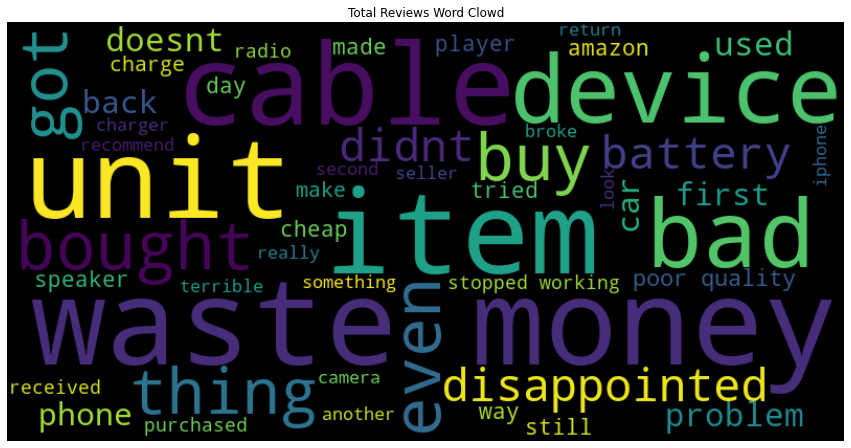

In [24]:
from wordcloud import  WordCloud
negative_reviews = reviews_data[(reviews_data['sentiment_score_ratings'] == 1) & (reviews_data['star_rating'] < 3)]['reviews_invalid_words_rem'].apply(lambda review: remove_most_common_words(review))
text = " ".join(review for review in negative_reviews)
wordcloud = WordCloud(background_color = 'black',width = 800, height = 400, max_words = 50)
wordcloud.generate(text)
fig = plt.figure(figsize = (15, 8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title('Total Reviews Word Clowd')
plt.show()

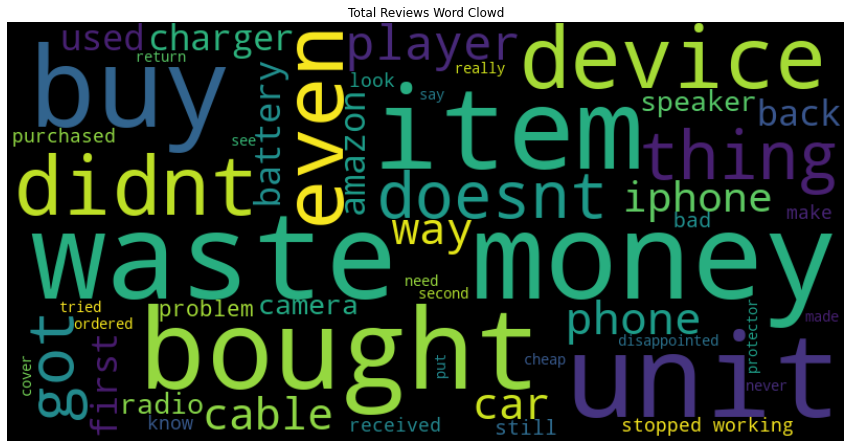

In [25]:
star_rating_1_reviews = reviews_data[reviews_data['star_rating'] == 1]['reviews_invalid_words_rem'].apply(lambda review: remove_most_common_words(review))
text = " ".join(review for review in star_rating_1_reviews)
wordcloud = WordCloud(background_color = 'black',width = 800, height = 400, max_words = 50)
wordcloud.generate(text)
fig = plt.figure(figsize = (15, 8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title('Total Reviews Word Clowd')
plt.show()

In [26]:
stop = stopwords.words('english')
def remove_stopwords(review):
    return " ".join([i for i in str(review).split() if i not in stop])
reviews_data["reviews_ml"] = reviews_data["reviews_invalid_words_rem"].apply(lambda review: remove_stopwords(review))
reviews_data.head()

,star_rating,review_body,reviews_pun_off,reviews_stop_rem,reviews_after_2_letter_rem,reviews_lemmatized,reviews_invalid_words_rem,sentiment_score,sentiment_score_ratings,reviews_ml
0,4.0,they were cheap and easy to install. way bette...,they were cheap and easy to install way bette...,cheap easy install way better cheap stock ones...,cheap easy install way better cheap stock ones...,cheap easy install way better cheap stock one ...,cheap easy install way better cheap stock one ...,0.8074,5.0,cheap easy install way better cheap stock one ...
1,1.0,i wouldn't really even give this one star. whe...,i wouldnt really even give this one star when...,wouldnt really even give one star got product ...,wouldnt really even give one star got product ...,wouldnt really even give one star got product ...,wouldnt really even give one star got product ...,-0.3597,2.0,wouldnt really even give one star got product ...
2,4.0,my 10 year old bought this for his new ipod an...,my 10 year old bought this for his new ipod an...,10 year old bought new ipod loves job perfectl...,year old bought new ipod loves job perfectly l...,year old bought new ipod love job perfectly lo...,year old bought new ipod love job perfectly lo...,0.9274,5.0,year old bought new ipod love job perfectly lo...
3,1.0,"case looks nice and fits great, however can't ...",case looks nice and fits great however cant s...,case looks nice fits great however cant say pr...,case looks nice fits great however cant say pr...,case look nice fit great however cant say prot...,case look nice fit great however cant say prot...,0.8633,5.0,case look nice fit great however cant say prot...
4,5.0,my previous kindle fire case was getting dull ...,my previous kindle fire case was getting dull ...,previous kindle fire case getting dull worn lo...,previous kindle fire case getting dull worn lo...,previous kindle fire case getting dull worn lo...,previous kindle fire case getting dull worn lo...,0.9169,5.0,previous kindle fire case getting dull worn lo...


In [27]:
inp = reviews_data['reviews_invalid_words_rem']
out = reviews_data['star_rating']
scores = {}

In [28]:
def text_model(inp, out, model, classifier_algorithm, lr):
    inp_transformed = model.fit_transform(inp)
    xtrain, xtest, ytrain, ytest = train_test_split(inp_transformed, out, test_size = 0.3)
    clf = OneVsRestClassifier(classifier_algorithm)
    clf.fit(xtrain, ytrain)
    ypred = clf.predict(xtest)
    print(classification_report(ytest, ypred))
    accuracy_score = clf.score(xtest, ytest)  
    print("Accuracy Score : ", accuracy_score)
    f1 = f1_score(ytest, ypred, average = 'weighted')
    print("f1 Score : ", f1)
    pred = clf.predict(xtest)
    pred_prob = clf.predict_proba(xtest)
    scores[str(classifier_algorithm)[:-2] + "_" + str(model)[:-2]] = list([accuracy_score, f1])

    # roc curve for classes
    fpr = {}
    tpr = {}
    thresh ={}

    n_class = 5

    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(ytest, pred_prob[:,i], pos_label = i+1)
    plt.plot(fpr[0], tpr[0], color = 'red', label = 'Class 1 vs Rest')
    plt.plot(fpr[1], tpr[1], color = 'green', label = 'Class 2 vs Rest')
    plt.plot(fpr[2], tpr[2], color = 'blue', label = 'Class 3 vs Rest')
    plt.plot(fpr[3], tpr[3], color = 'purple', label = 'Class 4 vs Rest')
    plt.plot(fpr[4], tpr[4], color = 'brown', label = 'Class 5 vs Rest')
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.show()
    if lr == 1:
        words = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coefficient_df = pd.DataFrame({'Words' : words, 'Coefficients' : coef})
        coefficient_df['Coefficients'] = coefficient_df['Coefficients'] * -1
        fig, axs = plt.subplots(2,figsize = (20,15))
        axs[0].title.set_text('Top positive words')
        sns.barplot(x = 'Words', y = 'Coefficients', data = coefficient_df.sort_values('Coefficients', ascending = False).head(20),ax = axs[0])
        axs[1].title.set_text('Top negative words')
        axs[1].invert_yaxis()
        sns.barplot(x = 'Words', y = 'Coefficients', data = coefficient_df.sort_values('Coefficients', ascending = True).head(20), ax = axs[1])
        plt.show()

# LR and Count vectoriser

              precision    recall  f1-score   support

         1.0       0.74      0.80      0.77      8926
         2.0       0.74      0.71      0.72      9062
         3.0       0.69      0.66      0.67      9028
         4.0       0.66      0.58      0.62      8940
         5.0       0.69      0.76      0.72      9044

    accuracy                           0.70     45000
   macro avg       0.70      0.70      0.70     45000
weighted avg       0.70      0.70      0.70     45000

Accuracy Score :  0.7033111111111111
f1 Score :  0.7015411542771991


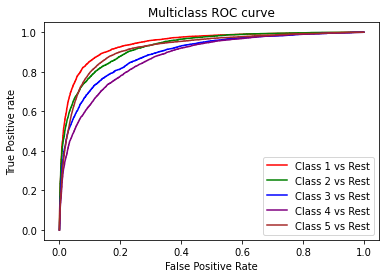

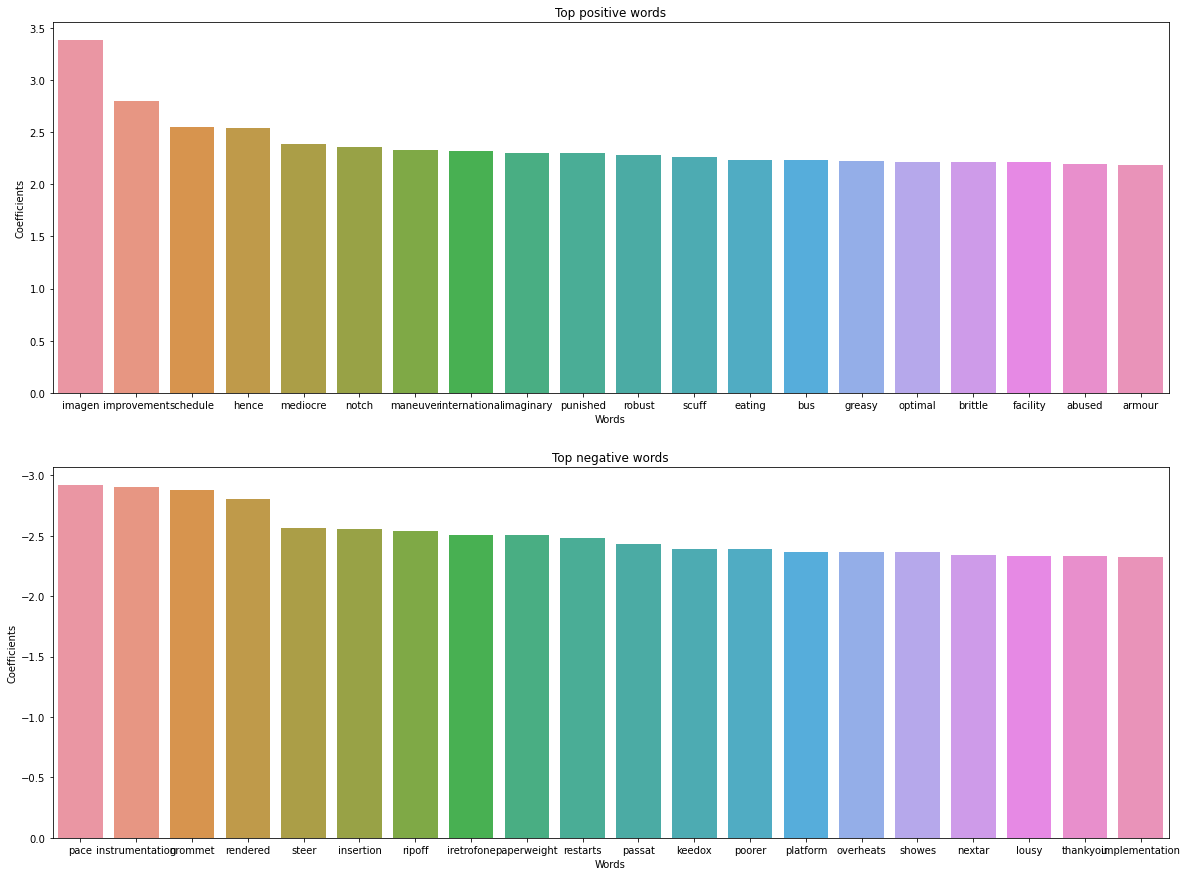

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(ngram_range = (1, 1))
text_model(inp, out, count_vect, LogisticRegression(max_iter = 2000), 1)

# LR and TF IDF vectoriser

              precision    recall  f1-score   support

         1.0       0.67      0.75      0.71      8941
         2.0       0.64      0.60      0.62      9133
         3.0       0.59      0.56      0.57      9012
         4.0       0.57      0.51      0.54      8926
         5.0       0.66      0.73      0.69      8988

    accuracy                           0.63     45000
   macro avg       0.63      0.63      0.63     45000
weighted avg       0.63      0.63      0.63     45000

Accuracy Score :  0.6302888888888889
f1 Score :  0.6274725672439823


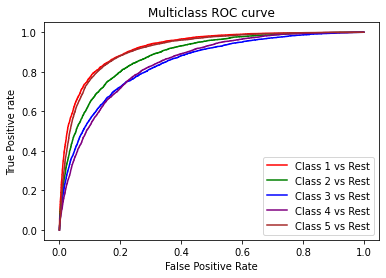

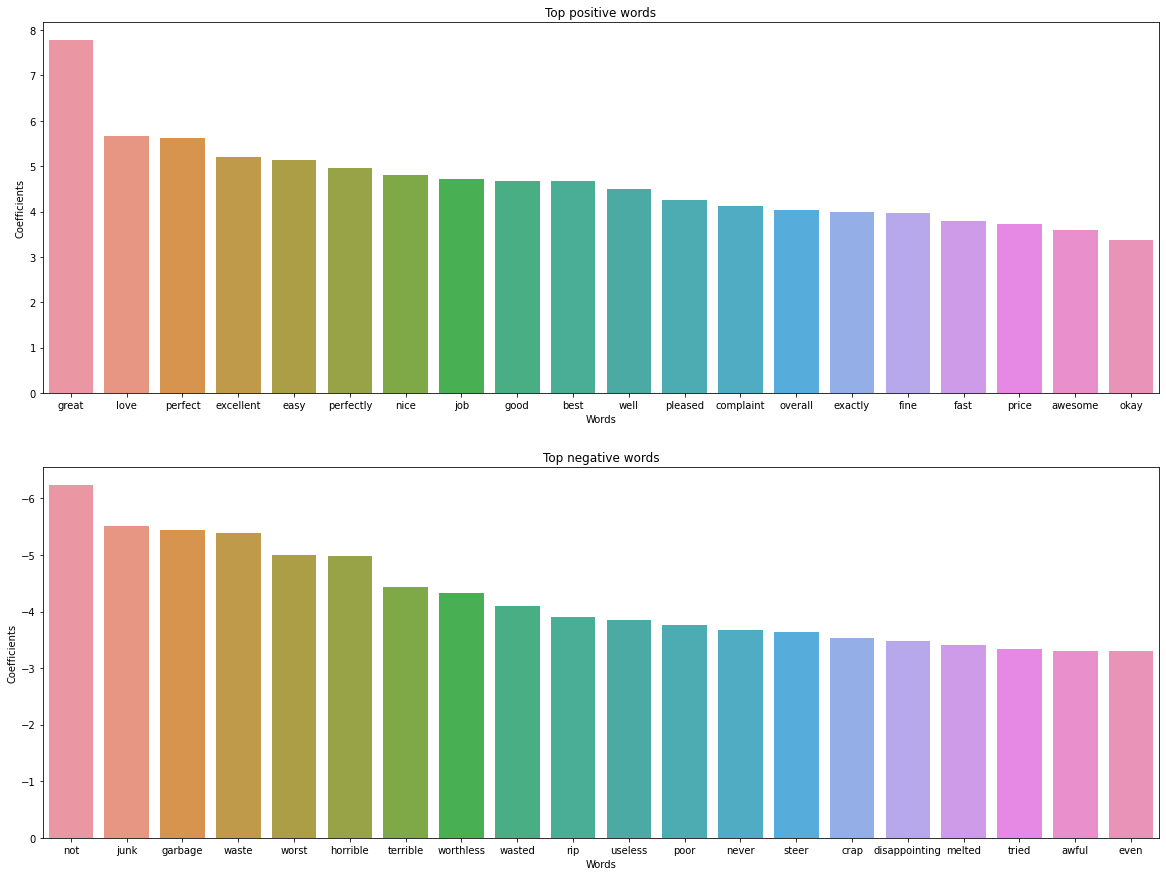

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
text_model(inp, out, tfidf, LogisticRegression(max_iter = 2000), 1)

# RF and Count Vectoriser

              precision    recall  f1-score   support

         1.0       0.92      0.96      0.94      8866
         2.0       0.98      0.97      0.97      9014
         3.0       0.94      0.93      0.94      8992
         4.0       0.86      0.84      0.85      9055
         5.0       0.85      0.85      0.85      9073

    accuracy                           0.91     45000
   macro avg       0.91      0.91      0.91     45000
weighted avg       0.91      0.91      0.91     45000

Accuracy Score :  0.9098666666666667
f1 Score :  0.909747762175302


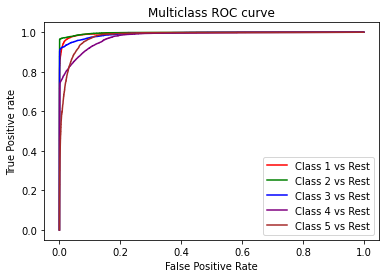

In [31]:
count_vect = CountVectorizer(ngram_range = (1, 1))
text_model(inp, out, count_vect, RandomForestClassifier(), 0)

# RF and TF IDF vectoriser

              precision    recall  f1-score   support

         1.0       0.93      0.95      0.94      9053
         2.0       0.98      0.97      0.97      8963
         3.0       0.95      0.93      0.94      8984
         4.0       0.87      0.84      0.86      8974
         5.0       0.84      0.88      0.86      9026

    accuracy                           0.91     45000
   macro avg       0.91      0.91      0.91     45000
weighted avg       0.91      0.91      0.91     45000

Accuracy Score :  0.9130444444444444
f1 Score :  0.9130671272454843


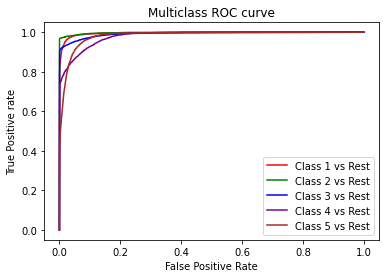

In [32]:
tfidf = TfidfVectorizer()
text_model(inp, out, tfidf, RandomForestClassifier(), 0)

Thus it is seen Random Forest and TF-IDF classifies better than other models

# TOPIC MODELLING

In [28]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


def nouns_adj(text):
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if   is_noun_adj(pos)]
    return ' '.join(nouns_adj)

[nltk_data] Downloading package punkt to /home/harrish/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/harrish/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [29]:
reviews_data["reviews_ml_only_nouns_adj"] = reviews_data["reviews_ml"].apply(lambda review: nouns_adj(review))
reviews_data.head()

,star_rating,review_body,reviews_pun_off,reviews_stop_rem,reviews_after_2_letter_rem,reviews_lemmatized,reviews_invalid_words_rem,sentiment_score,sentiment_score_ratings,reviews_ml,reviews_ml_only_nouns_adj
0,4.0,they were cheap and easy to install. way bette...,they were cheap and easy to install way bette...,cheap easy install way better cheap stock ones...,cheap easy install way better cheap stock ones...,cheap easy install way better cheap stock one ...,cheap easy install way better cheap stock one ...,0.8074,5.0,cheap easy install way better cheap stock one ...,cheap easy install way cheap stock anyone
1,1.0,i wouldn't really even give this one star. whe...,i wouldnt really even give this one star when...,wouldnt really even give one star got product ...,wouldnt really even give one star got product ...,wouldnt really even give one star got product ...,wouldnt really even give one star got product ...,-0.3597,2.0,wouldnt really even give one star got product ...,wouldnt star product next time didnt sound poo...
2,4.0,my 10 year old bought this for his new ipod an...,my 10 year old bought this for his new ipod an...,10 year old bought new ipod loves job perfectl...,year old bought new ipod loves job perfectly l...,year old bought new ipod love job perfectly lo...,year old bought new ipod love job perfectly lo...,0.9274,5.0,year old bought new ipod love job perfectly lo...,year old new ipod job pattern
3,1.0,"case looks nice and fits great, however can't ...",case looks nice and fits great however cant s...,case looks nice fits great however cant say pr...,case looks nice fits great however cant say pr...,case look nice fit great however cant say prot...,case look nice fit great however cant say prot...,0.8633,5.0,case look nice fit great however cant say prot...,case nice fit great cant protects ipod case gl...
4,5.0,my previous kindle fire case was getting dull ...,my previous kindle fire case was getting dull ...,previous kindle fire case getting dull worn lo...,previous kindle fire case getting dull worn lo...,previous kindle fire case getting dull worn lo...,previous kindle fire case getting dull worn lo...,0.9169,5.0,previous kindle fire case getting dull worn lo...,previous kindle fire case dull worn inexpensiv...


In [30]:
corpora = reviews_data["reviews_ml"].values
tokenized = [corpus.split(" ") for corpus in corpora]
vocabulary = Dictionary(tokenized)
vocabulary.filter_extremes(no_below = 10, no_above = 0.2)
bow = [vocabulary.doc2bow(doc) for doc in tokenized]

In [39]:
corpora_adj_nouns = reviews_data["reviews_ml_only_nouns_adj"].values
tokenized_adj_nouns = [corpus.split(" ") for corpus in corpora_adj_nouns]
vocabulary_adj_nouns = Dictionary(tokenized_adj_nouns)
vocabulary_adj_nouns.filter_extremes(no_below = 10, no_above = 0.2)
bow_adj_nouns = [vocabulary_adj_nouns.doc2bow(doc) for doc in tokenized_adj_nouns]

In [32]:
def compute_coherence_values(dictionary, corpus, texts, limit, start = 2, step = 2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus = corpus, id2word = dictionary, num_topics = num_topics, random_state = 30)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

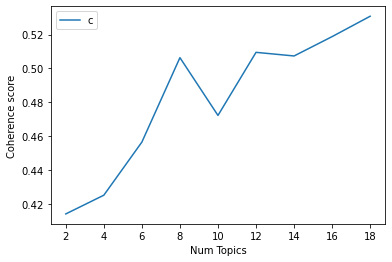

In [41]:
model_list, coherence_values = compute_coherence_values(dictionary = vocabulary, corpus = bow, texts = tokenized, start = 2, limit = 20, step = 2)
limit = 20
start = 2
step = 2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [34]:
lda_model = LdaModel(corpus = bow, id2word = vocabulary, num_topics = 12, random_state = 30)

In [35]:
for topic in range(0, 12):
    print(f"\nTopic {topic+1}:")
    for token, frequency in lda_model.show_topic(topic, topn = 20):
        print(f" {token}, {frequency}")


Topic 1:
 radio, 0.029644573107361794
 unit, 0.022289669141173363
 antenna, 0.0146502535790205
 instruction, 0.014390673488378525
 get, 0.009692336432635784
 support, 0.009430991485714912
 would, 0.009344925172626972
 product, 0.008593499660491943
 poor, 0.00843600369989872
 find, 0.008333981037139893
 system, 0.007316754665225744
 could, 0.0066347005777060986
 use, 0.00650201877579093
 manual, 0.006454364862293005
 need, 0.00616681482642889
 install, 0.006035204511135817
 installed, 0.005910288076847792
 software, 0.005817335564643145
 station, 0.005519349128007889
 signal, 0.0053057679906487465

Topic 2:
 like, 0.025875024497509003
 product, 0.02207385003566742
 look, 0.012019110843539238
 better, 0.011882851831614971
 picture, 0.011522043496370316
 say, 0.009656218811869621
 cheap, 0.00961284153163433
 would, 0.009311143308877945
 made, 0.008033358491957188
 thing, 0.007875518873333931
 much, 0.007520558312535286
 item, 0.007452703546732664
 description, 0.007152962498366833
 make,

In [ ]:
# topic 1 : radio and manual
# topic 2 : audio systems and players
# topic 3 : camera
# topic 4 : battery and chargers 
# topic 5 : sound system
# topic 6 : screen protector
# topic 7 : car softwares and accessories
# topic 8 : amazon delivery
# topic 9 : fit bands
# topic 10 : liked featurs
# topic 11 : working of products
# topic 12 : phone cases

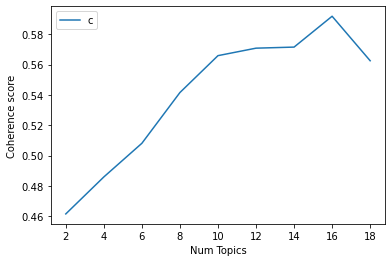

In [40]:
# only adjectives and nouns
model_list, coherence_values = compute_coherence_values(dictionary = vocabulary_adj_nouns, corpus = bow_adj_nouns, texts = tokenized_adj_nouns, start = 2, limit = 20, step = 2)
limit = 20
start = 2
step = 2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [42]:
lda_model_adj_nouns = LdaModel(corpus = bow_adj_nouns, id2word = vocabulary_adj_nouns, num_topics = 16, random_state = 30)

In [44]:
for topic in range(0, 16):
    print(f"\nTopic {topic+1}:")
    for token, frequency in lda_model_adj_nouns.show_topic(topic, topn = 25):
        print(f" {token}, {frequency}")


Topic 1:
 great, 0.11704351752996445
 good, 0.08474113047122955
 price, 0.061667151749134064
 sound, 0.05174153670668602
 speaker, 0.04906823858618736
 product, 0.037699971348047256
 quality, 0.03668686002492905
 easy, 0.03165377303957939
 use, 0.019092807546257973
 little, 0.018677039071917534
 love, 0.01430062297731638
 nice, 0.01365819200873375
 excellent, 0.010652456432580948
 small, 0.010604118928313255
 happy, 0.009966188110411167
 best, 0.00938420183956623
 look, 0.008765384554862976
 job, 0.008004904724657536
 size, 0.007972104474902153
 perfect, 0.00765036279335618
 son, 0.007577512413263321
 deal, 0.007396418135613203
 thanks, 0.007382815238088369
 buy, 0.00674783531576395
 value, 0.006070252973586321

Topic 2:
 month, 0.05363502725958824
 time, 0.033969078212976456
 year, 0.033510901033878326
 week, 0.033489517867565155
 last, 0.030350789427757263
 old, 0.02537459135055542
 new, 0.023644832894206047
 day, 0.02233724296092987
 use, 0.02042429894208908
 ive, 0.020270835608243

In [ ]:
# topic 1 : liked features of a product
# topic 2 : usage time
# topic 3 : chargers and connectors
# topic 4 : electrical technical reviews
# topic 5 : cases for ipod
# topic 6 : audio system
# topic 7 : iphone cases
# topic 8 : fit band
# topic 9 : screen protector
# topic 10 : car accessories
# topic 11 : holders for cup, gps
# topic 12 : battery and chargers
# topic 13 : replaced,refunded and returned products
# topic 14 : special features
# topic 15 : disliked features
# topic 16 : manual and support 

# Thus it is seen that reviews with nouns and adjectives alone gives better classification for topics